#Импорт библиотек

In [1]:
import zipfile
import os
import shutil
import random
import hashlib
import seaborn as sns
import os
import cv2

import gdown

from tqdm.auto import tqdm

from PIL import Image, ExifTags, ImageOps, ImageChops, ImageEnhance
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import numpy as np

from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split, ConcatDataset
import torch.nn.functional as F
import random

# Импорт необходимых библиотек
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from data_utils import setup_environment, download_and_extract, print_directory_structure, analyze_dataset
from data_cleaner import find_duplicates, visualize_duplicates, clean_dataset, copy_test_folder

In [31]:
# Установка зависимостей
!pip install gdown tqdm

#Загрузка файлов

In [4]:
# 1. Настройка окружения
DRIVE_DIR, DATASET_DIR, ZIP_PATH = setup_environment()

# 2. Загрузка данных
FILE_ID = "1ltYQh_bwNuJJ1nr91w3hZlGcnxrFOyF6"
download_and_extract(FILE_ID, ZIP_PATH, DATASET_DIR)

# 3. Очистка данных
CLASSES = ['NORMAL', 'PNEUMONIA']
TRAIN_DIR = os.path.join(DATASET_DIR, "chest_xray/train")
CLEAN_TRAIN_DIR = os.path.join(DATASET_DIR, "chest_xray_clean/train")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Данные распакованы в: /content/dataset


In [ ]:
import tarfile

# Пути к данным
DATASET_DIR_OCT = os.path.join(os.getcwd(), "dataset_oct")
ZIP_PATH_OCT = os.path.join(DRIVE_DIR, "OCT2017.tar.gz")

# Создание папки для датасета, если её нет
os.makedirs(DATASET_DIR_OCT, exist_ok=True)

# ID файла на Google Drive
file_id = "1Rfccuck7bN4HvO4BRr8RRorPcZw5v0AN"

# Загрузка архива, если он ещё не загружен
if os.path.exists(ZIP_PATH_OCT):
    print("Архив уже добавлен")
else:
    gdown.download(
        f"https://drive.google.com/uc?id={file_id}",
        ZIP_PATH_OCT,  # Исправлено на использование ZIP_PATH
        quiet=False,
    )

# Распаковка архива
with tarfile.open(ZIP_PATH_OCT, 'r:gz') as tar_ref:
        tar_ref.extractall(DATASET_DIR_OCT) # Распаковка в папку dataset_oct

# Проверка структуры папок
print(f"Количество папок: {len(os.listdir(DATASET_DIR_OCT))}")


#EDA

##Анализ структуры данных (исходные)

In [30]:
!rm -rf '/content/dataset/chest_xray/resized_train'

In [31]:
!ls '/content/dataset/chest_xray/resized_train'

ls: cannot access '/content/dataset/chest_xray/resized_train': No such file or directory



Создаем вертикальный график с новыми цветами...


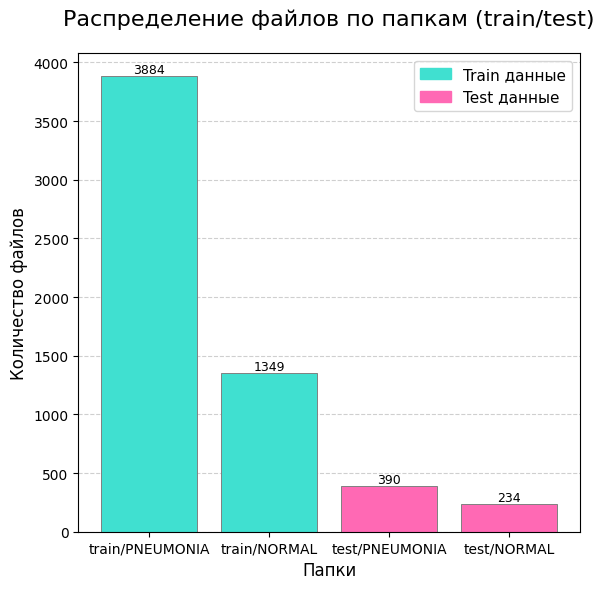


Статистика:
Train данных: 2 папок, 5233 файлов
Test данных: 2 папок, 624 файлов
Соотношение test/train: 0.12


In [32]:
analyze_dataset(src_dir)

In [14]:
print_directory_structure(clean_dir)


+ chest_xray_clean/
  + test/
    - .DS_Store
    + PNEUMONIA/
      - person174_bacteria_832.jpeg
      - person78_bacteria_381.jpeg
      - person149_bacteria_713.jpeg
      - person3_virus_16.jpeg
      - person1682_virus_2899.jpeg
      - person151_bacteria_718.jpeg
      - person161_bacteria_759.jpeg
      - person140_bacteria_667.jpeg
      - person72_virus_133.jpeg
      - person1685_virus_2903.jpeg
      ... (ещё 380 файлов скрыто)
    + NORMAL/
      - NORMAL2-IM-0290-0001.jpeg
      - NORMAL2-IM-0289-0001.jpeg
      - IM-0061-0001.jpeg
      - NORMAL2-IM-0112-0001.jpeg
      - IM-0095-0001.jpeg
      - NORMAL2-IM-0346-0001.jpeg
      - IM-0043-0001.jpeg
      - NORMAL2-IM-0201-0001.jpeg
      - NORMAL2-IM-0012-0001.jpeg
      - NORMAL2-IM-0095-0001.jpeg
      ... (ещё 224 файлов скрыто)
  + train/
    + PNEUMONIA/
      - person1863_bacteria_4735.jpeg
      - person1279_bacteria_3242.jpeg
      - person11_bacteria_45.jpeg
      - person470_bacteria_1999.jpeg
      - person393

##Анализ дубликатов рентгеновских снимков


Класс: NORMAL
Всего пар дубликатов: 1


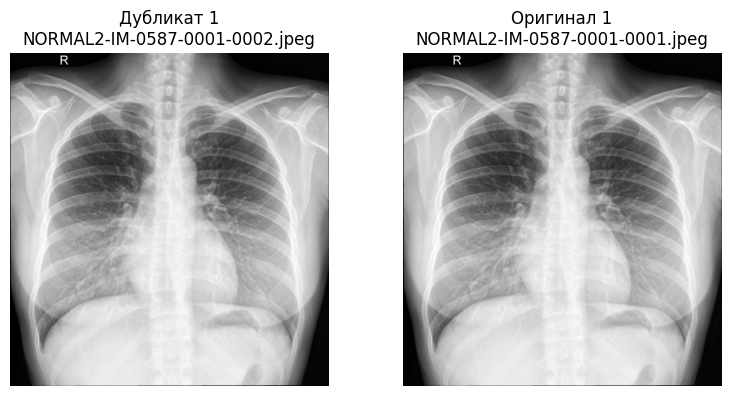


Класс: PNEUMONIA
Всего пар дубликатов: 25


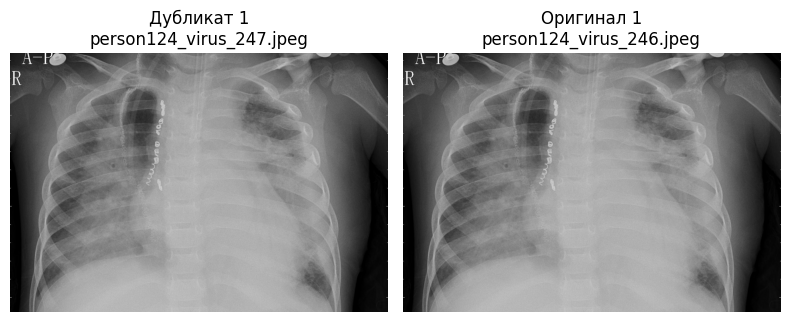

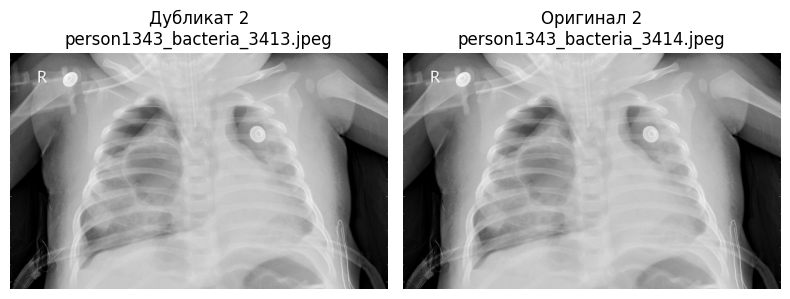

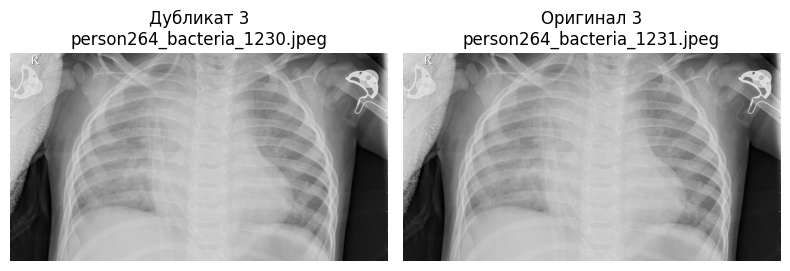

Обработка классов: 100%|██████████| 2/2 [00:08<00:00,  4.23s/it]


Итоги:
Скопировано уникальных файлов: 5206
Пропущено дубликатов: 26
Очищенный датасет сохранен в: /content/dataset/chest_xray_clean/train


In [11]:
# Поиск дубликатов
duplicates_dict = {}
all_duplicates_files = {}

for cls in CLASSES:
    path = os.path.join(TRAIN_DIR, cls)
    dup_list, dup_files = find_duplicates(path)
    if dup_list:
        duplicates_dict[cls] = dup_list
        all_duplicates_files[cls] = dup_files

# Визуализация
if duplicates_dict:
    visualize_duplicates(duplicates_dict)
else:
    print("Дубликаты не найдены")

# Создание чистого датасета
clean_dataset_path = clean_dataset(
    TRAIN_DIR,
    CLEAN_TRAIN_DIR,
    CLASSES,
    all_duplicates_files
)

print(f"Очищенный датасет сохранен в: {clean_dataset_path}")

In [10]:
src_dir = os.path.join(DATASET_DIR, "chest_xray")
clean_dir = os.path.join(DATASET_DIR, "chest_xray_clean")
copy_test_folder(src_dir, clean_dir)

Папка test скопирована в /content/dataset/chest_xray_clean/test


'/content/dataset/chest_xray_clean/test'

##Анализ структуры данных (очищенные)


Создаем вертикальный график с новыми цветами...


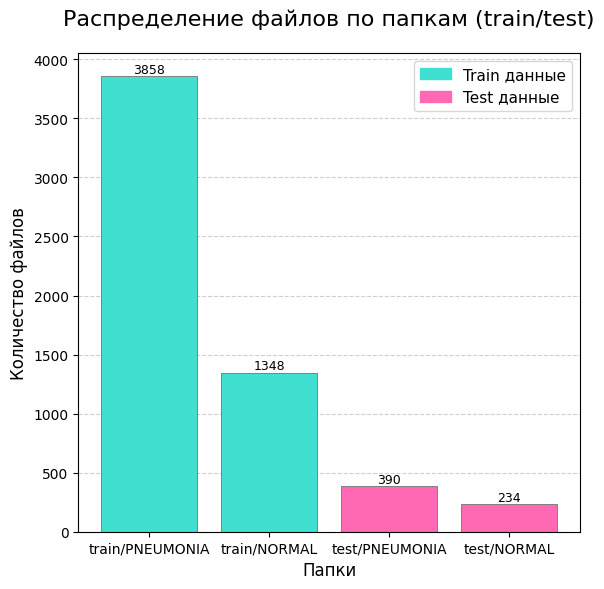


Статистика:
Train данных: 2 папок, 5206 файлов
Test данных: 2 папок, 624 файлов
Соотношение test/train: 0.12


In [15]:
analyze_dataset(clean_dir)

##Анализ дубликатов OCT

In [8]:
# Пути к папкам
DATASET_DIR = 'dataset_oct/OCT2017/train'
CLEAN_DATASET_DIR = 'dataset_clean/OCT2017/train'  # Папка для очищенного датасета
classes = ['CNV', 'DME', 'DRUSEN', 'NORMAL']

# Словарь для хранения дубликатов по классам
duplicates_dict = {}
# Словарь для хранения всех файлов-дубликатов по классам
all_duplicates_files = {}

# Поиск дубликатов для каждого класса
for cls in tqdm(classes, desc="Поиск дубликатов"):
    path = os.path.join(DATASET_DIR, cls)
    dup_list, dup_files = find_duplicates(path)
    if dup_list:
        duplicates_dict[cls] = dup_list
        all_duplicates_files[cls] = dup_files

# Визуализация дубликатов (если они есть)
if duplicates_dict:
    show_duplicates(duplicates_dict)
else:
    print("\nДубликаты не найдены.")

# Создание очищенного датасета
print("\nСоздание очищенного датасета...")
total_copied = 0
total_skipped = 0

for cls in tqdm(classes, desc="Обработка классов"):
    # Пути к исходной и новой папкам класса
    src_class_dir = os.path.join(DATASET_DIR, cls)
    dst_class_dir = os.path.join(CLEAN_DATASET_DIR, cls)

    # Получаем множество дубликатов для этого класса
    dup_files = all_duplicates_files.get(cls, set())

    # Копируем уникальные файлы
    copied, skipped = copy_unique_files(src_class_dir, dst_class_dir, dup_files)
    total_copied += copied
    total_skipped += skipped

    print(f"\nКласс {cls}:")
    print(f"  Скопировано уникальных файлов: {copied}")
    print(f"  Пропущено дубликатов: {skipped}")

print(f"\nИтоги:")
print(f"Всего скопировано уникальных файлов: {total_copied}")
print(f"Всего пропущено дубликатов: {total_skipped}")
print(f"\nОчищенный датасет сохранен в: {CLEAN_DATASET_DIR}")

Поиск дубликатов: 100%|██████████| 4/4 [00:00<00:00, 10551.71it/s]



Дубликаты не найдены.

Создание очищенного датасета...


Обработка классов: 100%|██████████| 4/4 [00:00<00:00, 3680.02it/s]


Класс CNV:
  Скопировано уникальных файлов: 0
  Пропущено дубликатов: 0

Класс DME:
  Скопировано уникальных файлов: 0
  Пропущено дубликатов: 0

Класс DRUSEN:
  Скопировано уникальных файлов: 0
  Пропущено дубликатов: 0

Класс NORMAL:
  Скопировано уникальных файлов: 0
  Пропущено дубликатов: 0

Итоги:
Всего скопировано уникальных файлов: 0
Всего пропущено дубликатов: 0

Очищенный датасет сохранен в: dataset_clean/OCT2017/train


## Вывод произвольных изображений

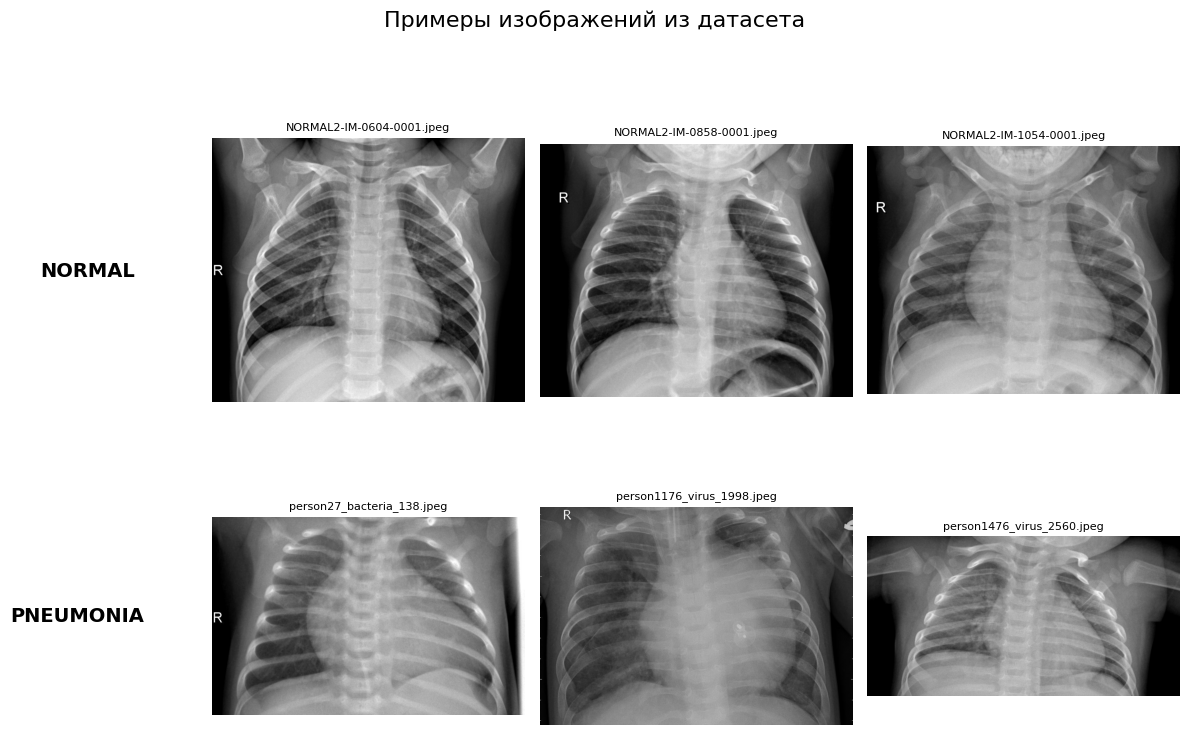

In [9]:
import os
import random
import matplotlib.pyplot as plt
from PIL import Image

DATASET_DIR = 'dataset/chest_xray/train'
classes = ['NORMAL', 'PNEUMONIA']

# Создаем фигуру с двумя рядами (по одному на класс) и 3 столбцами (по числу изображений)
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 8))
fig.suptitle('Примеры изображений из датасета', fontsize=16, y=1.02)  # Общий заголовок

for i, class_name in enumerate(classes):
    class_path = os.path.join(DATASET_DIR, class_name)
    images = os.listdir(class_path)
    random_images = random.sample(images, 3)  # Выбираем 3 случайных изображения

    # Добавляем заголовок для всей строки (класса)
    axes[i, 0].annotate(
        class_name,
        xy=(0, 0.5),
        xytext=(-axes[i, 0].yaxis.labelpad - 15, 0),
        xycoords=axes[i, 0].yaxis.label,
        textcoords='offset points',
        fontsize=14,
        ha='right',
        va='center',
        weight='bold'
    )

    for j, img_name in enumerate(random_images):
        img_path = os.path.join(class_path, img_name)
        img = Image.open(img_path)

        axes[i, j].imshow(img, cmap='gray')
        axes[i, j].set_title(img_name, fontsize=8)
        axes[i, j].axis('off')

plt.tight_layout()
plt.show()

## Анализ размеров изображений

### Графики распределения

Минимальная ширина: 384, Минимальная высота: 127
Максимальная ширина: 2916, Максимальная высота: 2713
Средняя ширина: 1327.64, Средняя высота: 970.30


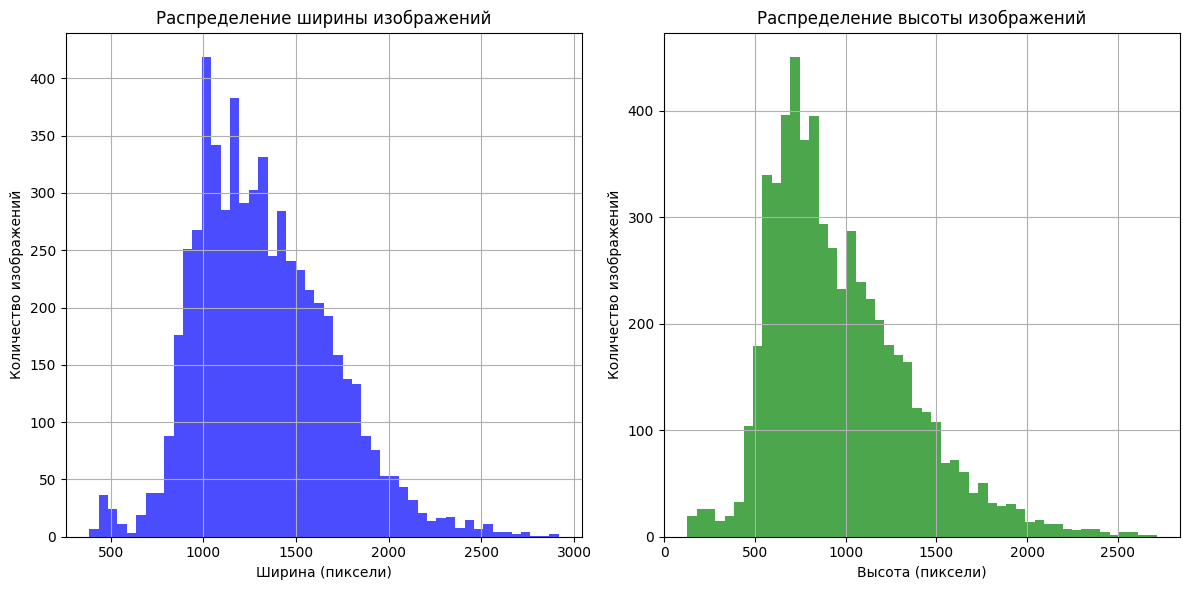

In [38]:
import os
from PIL import Image
import matplotlib.pyplot as plt

# Путь к папке с данными
train_dir = os.path.join(clean_dir, "train")
test_dir = os.path.join(clean_dir, "test")

# Функция для получения размеров изображений
def get_image_sizes(image_dir):
    """
    Возвращает списки ширин и высот всех изображений в указанной папке.

    :param image_dir: Путь к папке с изображениями.
    :return: Списки ширин и высот.
    """
    widths = []
    heights = []

    # Проходим по всем подпапкам (NORMAL и PNEUMONIA)
    for class_name in ["NORMAL", "PNEUMONIA"]:
        class_dir = os.path.join(image_dir, class_name)

        # Проверяем, что папка существует
        if os.path.exists(class_dir):
            # Проходим по всем изображениям в папке
            for image_name in os.listdir(class_dir):
                if image_name.endswith(".jpeg"):  # Проверяем, что это изображение
                    image_path = os.path.join(class_dir, image_name)

                    # Открываем изображение и получаем его размер
                    with Image.open(image_path) as img:
                        width, height = img.size
                        widths.append(width)
                        heights.append(height)

    return widths, heights

# Получаем размеры изображений для train и test
train_widths, train_heights = get_image_sizes(train_dir)
test_widths, test_heights = get_image_sizes(test_dir)

# Объединяем размеры
all_widths = train_widths + test_widths
all_heights = train_heights + test_heights

# Вычисляем минимальное, максимальное и среднее значения для ширины и высоты
if all_widths and all_heights:
    min_width, max_width = min(all_widths), max(all_widths)
    min_height, max_height = min(all_heights), max(all_heights)
    avg_width = sum(all_widths) / len(all_widths)
    avg_height = sum(all_heights) / len(all_heights)

    print(f"Минимальная ширина: {min_width}, Минимальная высота: {min_height}")
    print(f"Максимальная ширина: {max_width}, Максимальная высота: {max_height}")
    print(f"Средняя ширина: {avg_width:.2f}, Средняя высота: {avg_height:.2f}")
else:
    print("Изображения не найдены.")

# Построение гистограмм распределения ширины и высоты
plt.figure(figsize=(12, 6))

# Гистограмма для ширины
plt.subplot(1, 2, 1)
plt.hist(all_widths, bins=50, color='blue', alpha=0.7)
plt.title("Распределение ширины изображений")
plt.xlabel("Ширина (пиксели)")
plt.ylabel("Количество изображений")
plt.grid(True)

# Гистограмма для высоты
plt.subplot(1, 2, 2)
plt.hist(all_heights, bins=50, color='green', alpha=0.7)
plt.title("Распределение высоты изображений")
plt.xlabel("Высота (пиксели)")
plt.ylabel("Количество изображений")
plt.grid(True)

plt.tight_layout()
plt.show()

### Графики распределения по двум классам

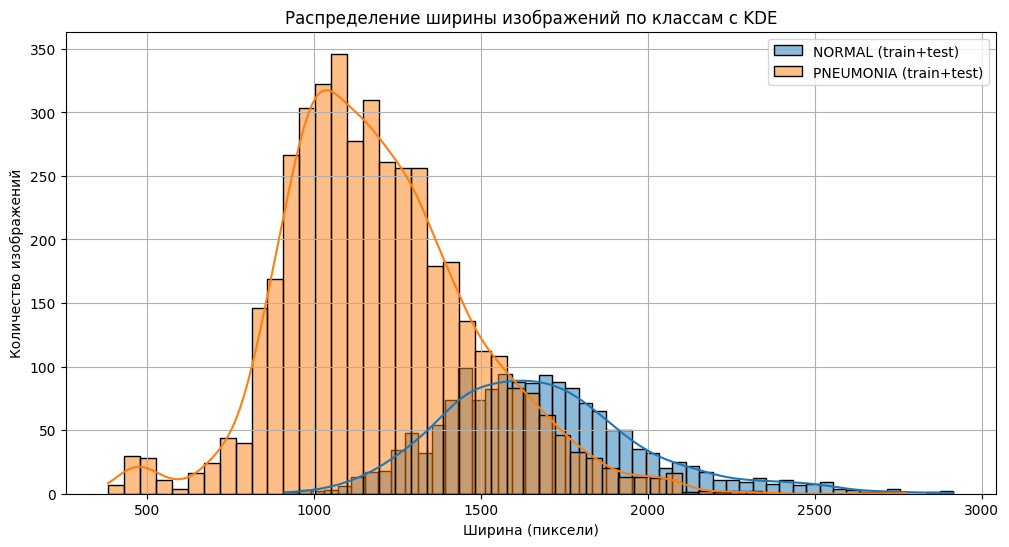

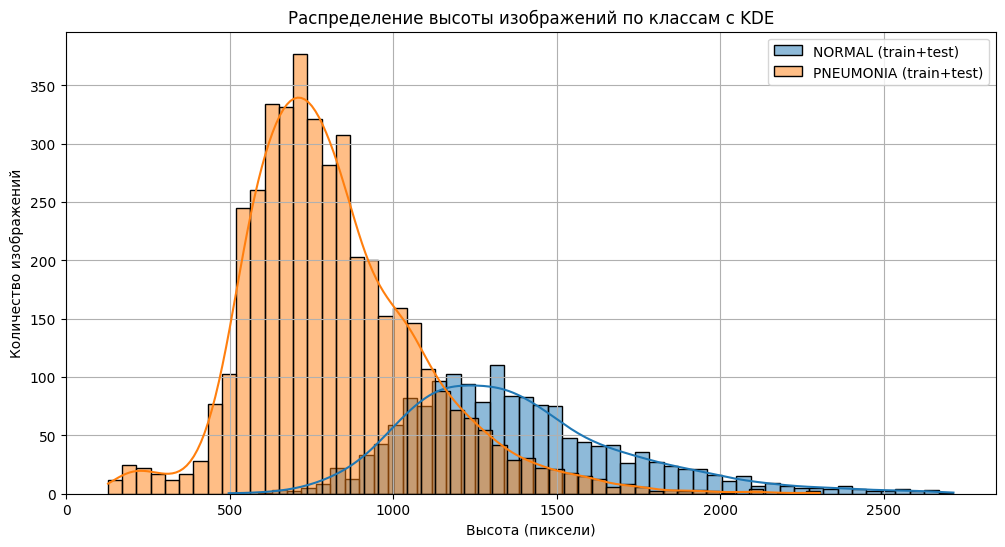

In [39]:
import os
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns

# Путь к папке с данными
train_dir = os.path.join(clean_dir, "train")
test_dir = os.path.join(clean_dir, "test")

# Функция для получения размеров изображений по классам
def get_image_sizes_by_class(image_dir):
    sizes_by_class = {"NORMAL": {"widths": [], "heights": []}, "PNEUMONIA": {"widths": [], "heights": []}}

    for class_name in sizes_by_class.keys():
        class_dir = os.path.join(image_dir, class_name)

        if os.path.exists(class_dir):
            for image_name in os.listdir(class_dir):
                if image_name.endswith(".jpeg"):  # Используйте .jpg или .jpeg в зависимости от ваших данных
                    image_path = os.path.join(class_dir, image_name)
                    with Image.open(image_path) as img:
                        width, height = img.size
                        sizes_by_class[class_name]["widths"].append(width)
                        sizes_by_class[class_name]["heights"].append(height)

    return sizes_by_class

# Получаем размеры изображений для train и test
train_sizes_by_class = get_image_sizes_by_class(train_dir)
test_sizes_by_class = get_image_sizes_by_class(test_dir)

# Построение гистограмм и кривых распределения для каждого класса
plt.figure(figsize=(12, 6))

# Объединяем данные для train и test
for class_name in train_sizes_by_class.keys():
    # Ширины для train и test
    train_widths = train_sizes_by_class[class_name]["widths"]
    test_widths = test_sizes_by_class[class_name]["widths"]
    all_widths = train_widths + test_widths

    # Гистограмма с KDE
    sns.histplot(all_widths, bins=50, kde=True, alpha=0.5, label=f"{class_name} (train+test)")


plt.title("Распределение ширины изображений по классам с KDE")
plt.xlabel("Ширина (пиксели)")
plt.ylabel("Количество изображений")
plt.legend()
plt.grid(True)
plt.show()

# Построение гистограмм и кривых распределения для высоты изображений
plt.figure(figsize=(12, 6))

# Объединяем данные для train и test
for class_name in train_sizes_by_class.keys():
    # Высоты для train и test
    train_heights = train_sizes_by_class[class_name]["heights"]
    test_heights = test_sizes_by_class[class_name]["heights"]
    all_heights = train_heights + test_heights

    # Гистограмма с KDE
    sns.histplot(all_heights, bins=50, kde=True, alpha=0.5, label=f"{class_name} (train+test)")

plt.title("Распределение высоты изображений по классам с KDE")
plt.xlabel("Высота (пиксели)")
plt.ylabel("Количество изображений")
plt.legend()
plt.grid(True)
plt.show()

Распределения отдельно по классам

Класс: NORMAL
  Ширина: мин=912, макс=2916, среднее=1685.91
  Высота: мин=496, макс=2713, среднее=1377.91


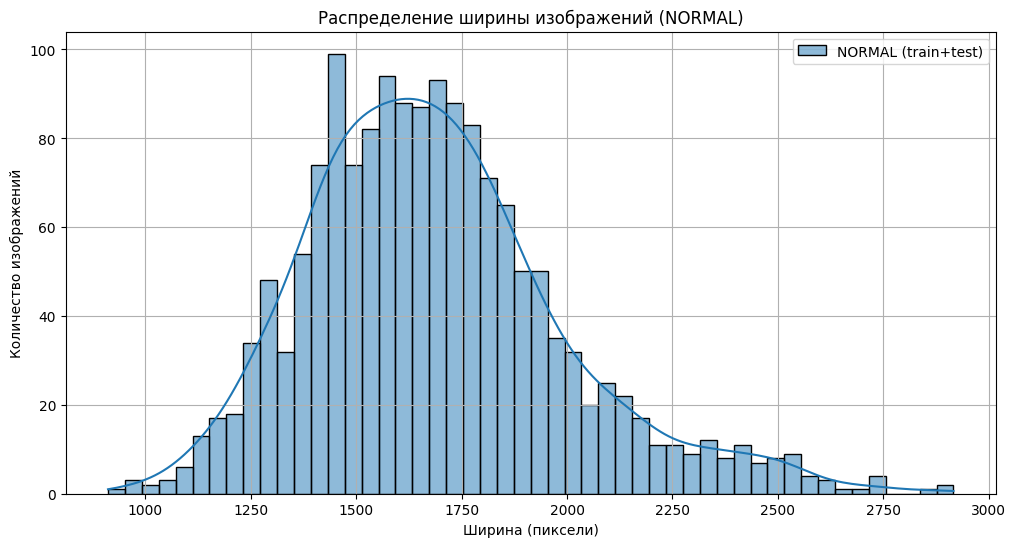

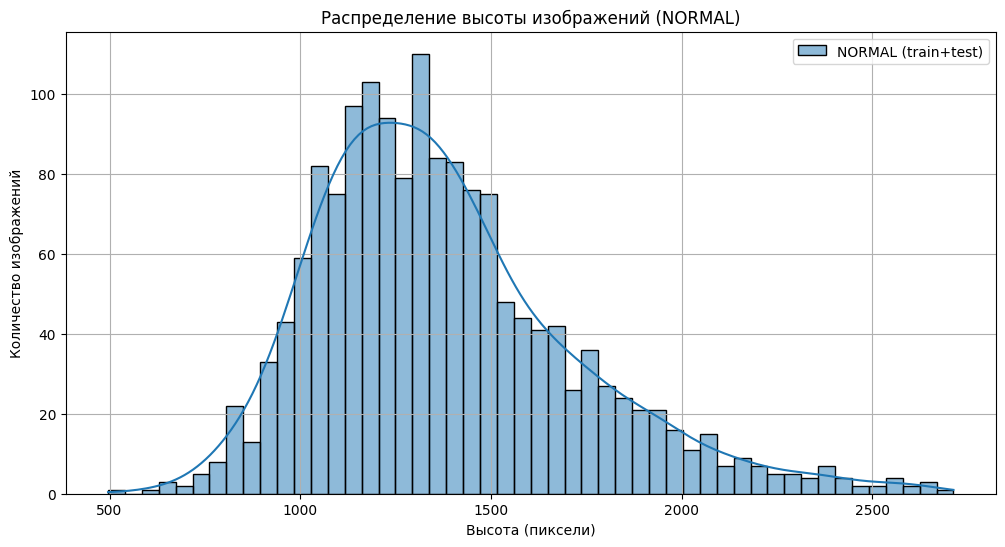

Класс: PNEUMONIA
  Ширина: мин=384, макс=2772, среднее=1194.22
  Высота: мин=127, макс=2304, среднее=818.51


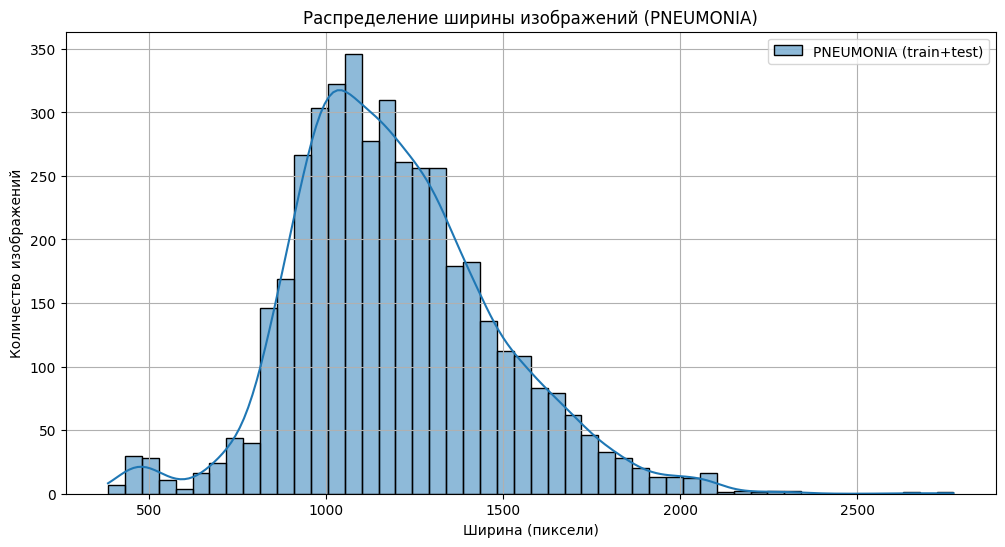

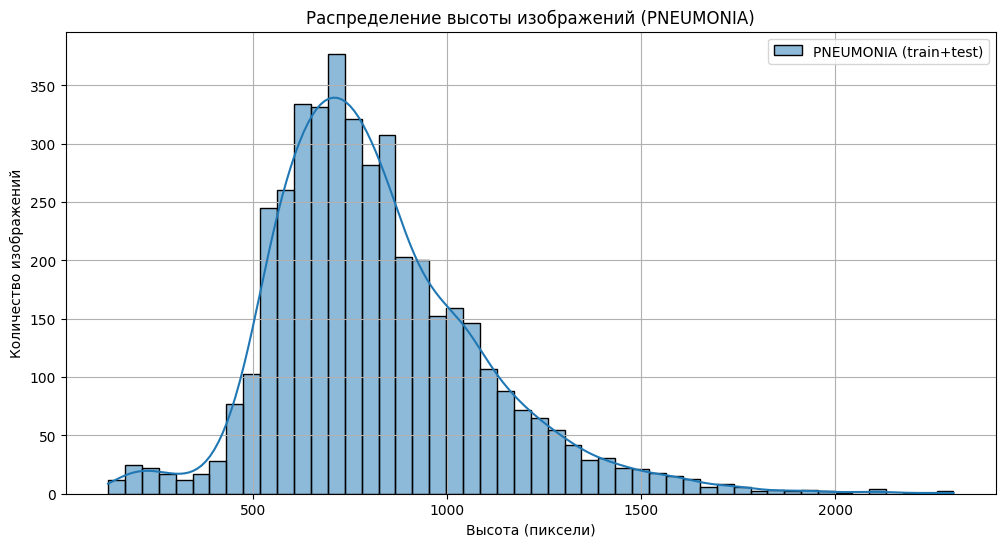

In [40]:
import os
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns

# Путь к папке с данными
train_dir = os.path.join(clean_dir, "train")
test_dir = os.path.join(clean_dir, "test")

# Функция для получения размеров изображений по классам
def get_image_sizes_by_class(image_dir):
    sizes_by_class = {"NORMAL": {"widths": [], "heights": []}, "PNEUMONIA": {"widths": [], "heights": []}}

    for class_name in sizes_by_class.keys():
        class_dir = os.path.join(image_dir, class_name)

        if os.path.exists(class_dir):
            for image_name in os.listdir(class_dir):
                if image_name.endswith(".jpeg"):  # Используйте .jpg или .jpeg в зависимости от ваших данных
                    image_path = os.path.join(class_dir, image_name)
                    with Image.open(image_path) as img:
                        width, height = img.size
                        sizes_by_class[class_name]["widths"].append(width)
                        sizes_by_class[class_name]["heights"].append(height)

    return sizes_by_class

# Функция для построения гистограмм и KDE
def plot_distribution(data, title, xlabel, class_name):
    """
    Строит гистограмму и KDE для данных.

    :param data: Данные для построения (ширина или высота).
    :param title: Заголовок графика.
    :param xlabel: Название оси X.
    :param class_name: Название класса (NORMAL или PNEUMONIA).
    """
    plt.figure(figsize=(12, 6))
    sns.histplot(data, bins=50, kde=True, alpha=0.5, label=f"{class_name} (train+test)")
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel("Количество изображений")
    plt.legend()
    plt.grid(True)
    plt.show()

# Получаем размеры изображений для train и test
train_sizes_by_class = get_image_sizes_by_class(train_dir)
test_sizes_by_class = get_image_sizes_by_class(test_dir)

# Анализ и визуализация для ширины и высоты
for class_name in train_sizes_by_class.keys():
    # Объединяем данные для train и test
    all_widths = train_sizes_by_class[class_name]["widths"] + test_sizes_by_class[class_name]["widths"]
    all_heights = train_sizes_by_class[class_name]["heights"] + test_sizes_by_class[class_name]["heights"]

    # Вычисляем минимальное, максимальное и среднее значения
    min_width, max_width = min(all_widths), max(all_widths)
    min_height, max_height = min(all_heights), max(all_heights)
    avg_width = sum(all_widths) / len(all_widths)
    avg_height = sum(all_heights) / len(all_heights)

    print(f"Класс: {class_name}")
    print(f"  Ширина: мин={min_width}, макс={max_width}, среднее={avg_width:.2f}")
    print(f"  Высота: мин={min_height}, макс={max_height}, среднее={avg_height:.2f}")

    # Визуализация распределения ширины
    plot_distribution(
        all_widths,
        title=f"Распределение ширины изображений ({class_name})",
        xlabel="Ширина (пиксели)",
        class_name=class_name
    )

    # Визуализация распределения высоты
    plot_distribution(
        all_heights,
        title=f"Распределение высоты изображений ({class_name})",
        xlabel="Высота (пиксели)",
        class_name=class_name
    )

## Анализ хвостов

Класс: NORMAL
  Ширина: мин=912, макс=2916, среднее=1686.38
  Высота: мин=496, макс=2713, среднее=1378.65


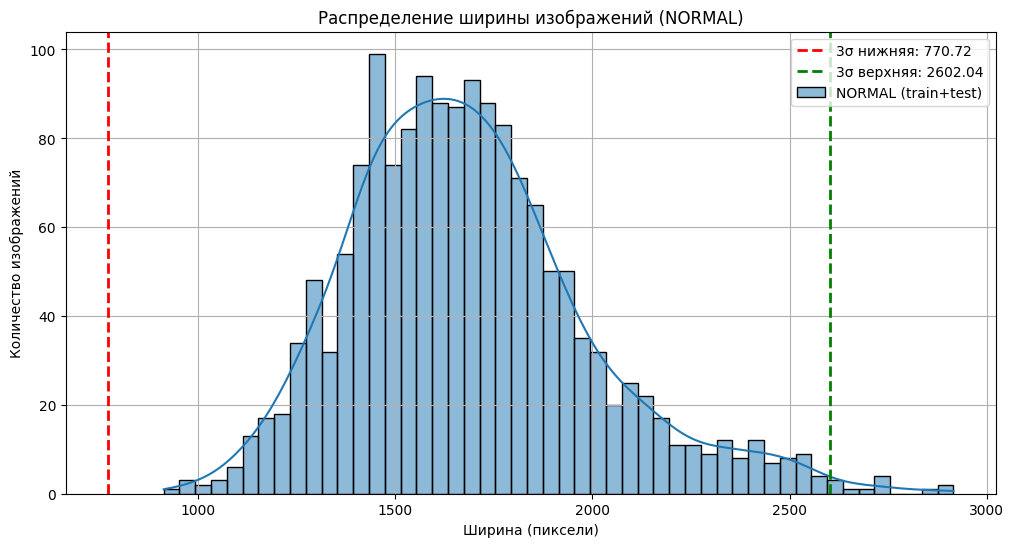

Список изображений, выходящих за пределы 3σ, сохранен в файл: ./outliers_width_NORMAL.txt
Количество изображений-выбросов: 12


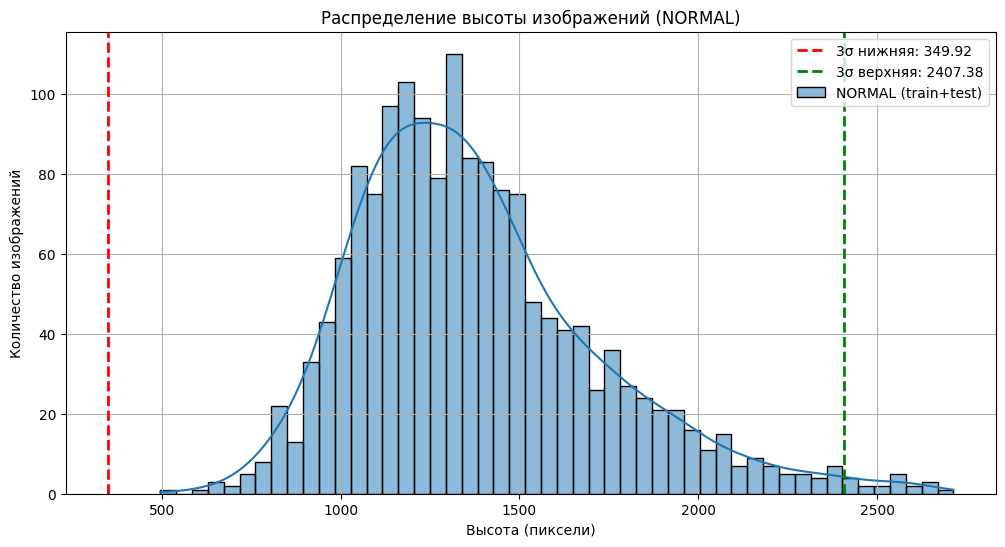

Список изображений, выходящих за пределы 3σ, сохранен в файл: ./outliers_height_NORMAL.txt
Количество изображений-выбросов: 19
Класс: PNEUMONIA
  Ширина: мин=384, макс=2772, среднее=1195.07
  Высота: мин=127, макс=2304, среднее=819.55


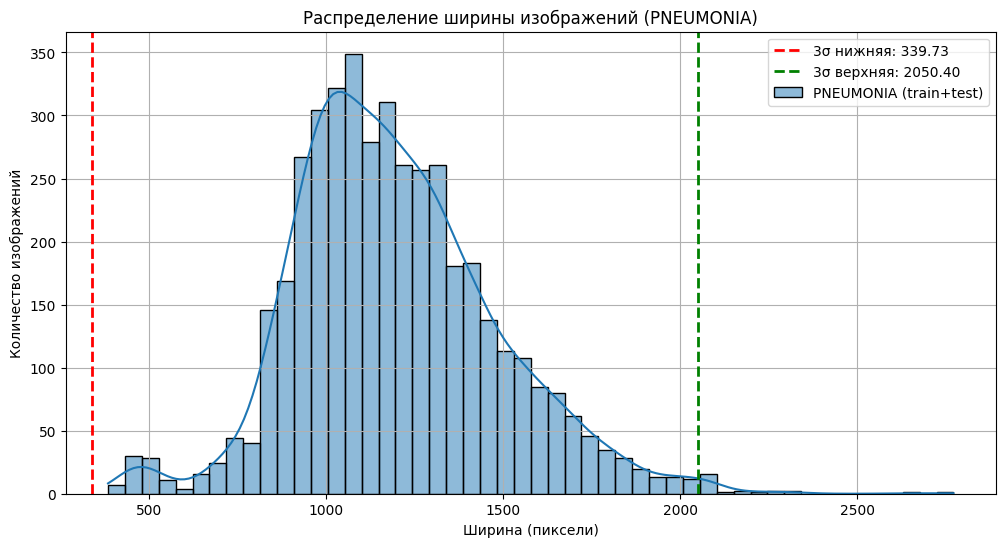

Список изображений, выходящих за пределы 3σ, сохранен в файл: ./outliers_width_PNEUMONIA.txt
Количество изображений-выбросов: 28


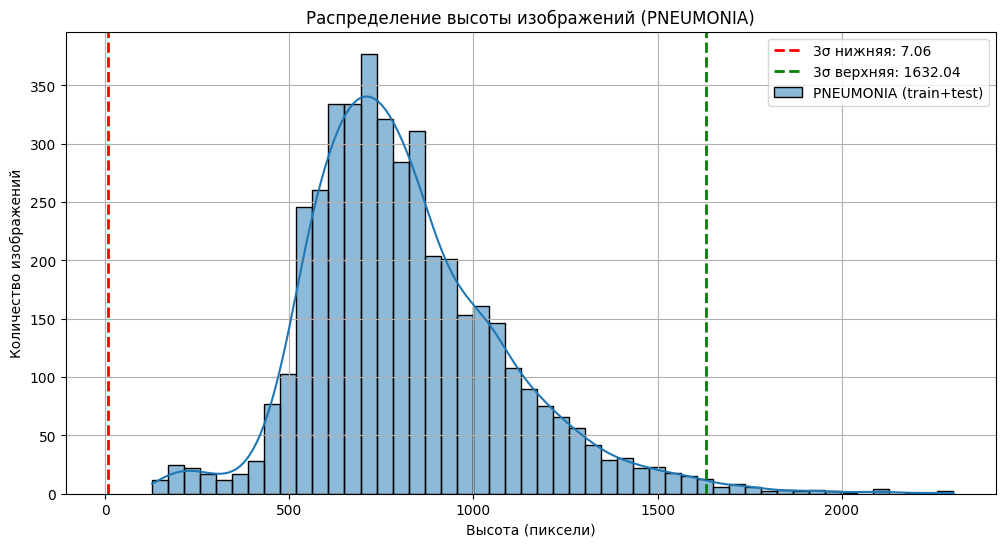

Список изображений, выходящих за пределы 3σ, сохранен в файл: ./outliers_height_PNEUMONIA.txt
Количество изображений-выбросов: 44


In [13]:
import os
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Путь к папке с данными
train_dir = os.path.join(clean_dir, "train")
test_dir = os.path.join(clean_dir, "test")

# Функция для получения размеров изображений по классам
def get_image_sizes_by_class(image_dir):
    sizes_by_class = {"NORMAL": {"widths": [], "heights": []}, "PNEUMONIA": {"widths": [], "heights": []}}

    for class_name in sizes_by_class.keys():
        class_dir = os.path.join(image_dir, class_name)

        if os.path.exists(class_dir):
            for image_name in os.listdir(class_dir):
                if image_name.endswith(".jpeg"):  # Используйте .jpg или .jpeg в зависимости от ваших данных
                    image_path = os.path.join(class_dir, image_name)
                    with Image.open(image_path) as img:
                        width, height = img.size
                        sizes_by_class[class_name]["widths"].append(width)
                        sizes_by_class[class_name]["heights"].append(height)

    return sizes_by_class

# Функция для построения гистограмм и KDE
def plot_distribution(data, title, xlabel, class_name, output_file_outliers):
    """
    Строит гистограмму и KDE для данных.

    :param data: Данные для построения (ширина или высота).
    :param title: Заголовок графика.
    :param xlabel: Название оси X.
    :param class_name: Название класса (NORMAL или PNEUMONIA).
    :param output_file_outliers: Файл для сохранения путей к изображениям-выбросам.
    """
    plt.figure(figsize=(12, 6))

    # Вычисляем среднее и стандартное отклонение
    mean = np.mean(data)
    std = np.std(data)
    lower_bound = mean - 3 * std
    upper_bound = mean + 3 * std

    # Гистограмма с KDE
    sns.histplot(data, bins=50, kde=True, alpha=0.5, label=f"{class_name} (train+test)")

    # Добавляем вертикальные линии для границ 3σ
    plt.axvline(lower_bound, color='red', linestyle='--', linewidth=2, label=f"3σ нижняя: {lower_bound:.2f}")
    plt.axvline(upper_bound, color='green', linestyle='--', linewidth=2, label=f"3σ верхняя: {upper_bound:.2f}")

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel("Количество изображений")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Находим изображения, выходящие за пределы диапазона
    outliers = []
    for image_dir in [train_dir, test_dir]:
        class_dir = os.path.join(image_dir, class_name)
        if os.path.exists(class_dir):
            for image_name in os.listdir(class_dir):
                if image_name.endswith(".jpeg"):
                    image_path = os.path.join(class_dir, image_name)
                    with Image.open(image_path) as img:
                        width, height = img.size
                        value = width if xlabel == "Ширина (пиксели)" else height
                        if value < lower_bound or value > upper_bound:
                            outliers.append(image_path)

    # Сохраняем пути к выбросам в файл
    with open(output_file_outliers, "w") as f:
        for outlier in outliers:
            f.write(f"{outlier}\n")

    # Подсчет количества выбросов
    outlier_count = len(outliers)
    print(f"Список изображений, выходящих за пределы 3σ, сохранен в файл: {output_file_outliers}")
    print(f"Количество изображений-выбросов: {outlier_count}")

# Получаем размеры изображений для train и test
train_sizes_by_class = get_image_sizes_by_class(train_dir)
test_sizes_by_class = get_image_sizes_by_class(test_dir)

# Анализ и визуализация для ширины и высоты
for class_name in train_sizes_by_class.keys():
    # Объединяем данные для train и test
    all_widths = train_sizes_by_class[class_name]["widths"] + test_sizes_by_class[class_name]["widths"]
    all_heights = train_sizes_by_class[class_name]["heights"] + test_sizes_by_class[class_name]["heights"]

    # Вычисляем минимальное, максимальное и среднее значения
    min_width, max_width = min(all_widths), max(all_widths)
    min_height, max_height = min(all_heights), max(all_heights)
    avg_width = sum(all_widths) / len(all_widths)
    avg_height = sum(all_heights) / len(all_heights)

    print(f"Класс: {class_name}")
    print(f"  Ширина: мин={min_width}, макс={max_width}, среднее={avg_width:.2f}")
    print(f"  Высота: мин={min_height}, макс={max_height}, среднее={avg_height:.2f}")

    # Визуализация распределения ширины
    plot_distribution(
        all_widths,
        title=f"Распределение ширины изображений ({class_name})",
        xlabel="Ширина (пиксели)",
        class_name=class_name,
        output_file_outliers=f"./outliers_width_{class_name}.txt"
    )

    # Визуализация распределения высоты
    plot_distribution(
        all_heights,
        title=f"Распределение высоты изображений ({class_name})",
        xlabel="Высота (пиксели)",
        class_name=class_name,
        output_file_outliers=f"./outliers_height_{class_name}.txt"
    )

### Хвосты

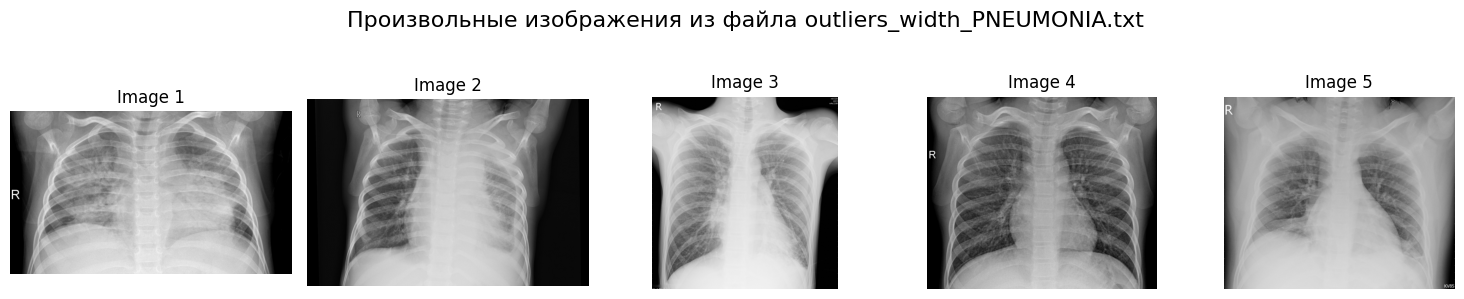

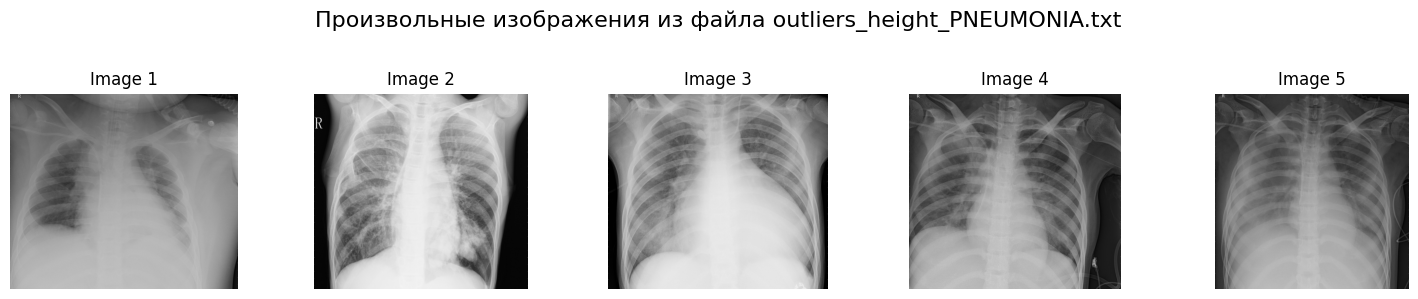

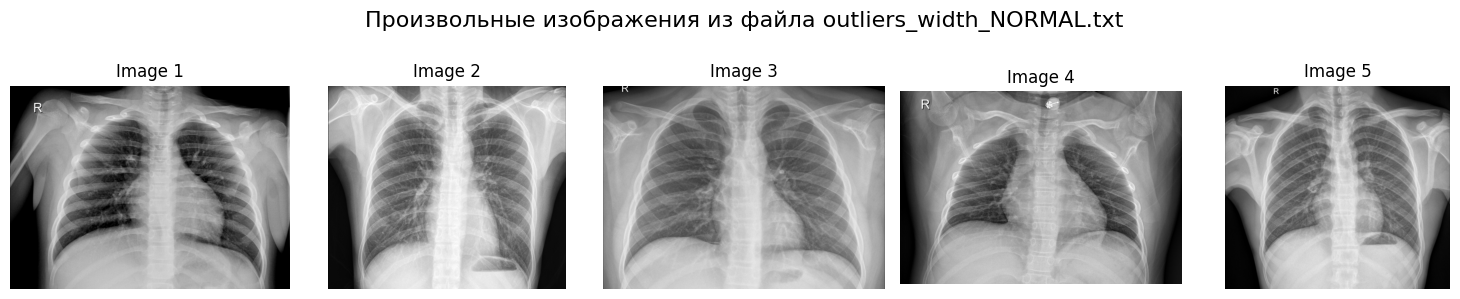

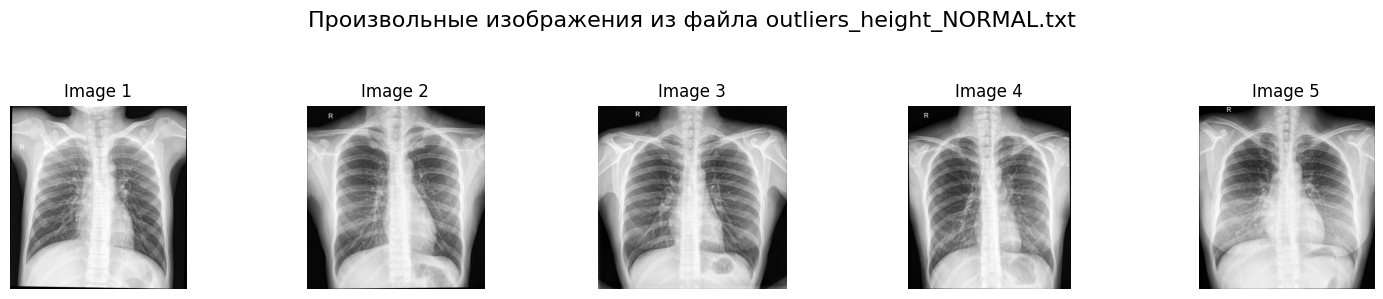

In [14]:
import random
from PIL import Image
import matplotlib.pyplot as plt

# Список файлов с выбросами
output_files = [
    'outliers_width_PNEUMONIA.txt',
    'outliers_height_PNEUMONIA.txt',
    'outliers_width_NORMAL.txt',
    'outliers_height_NORMAL.txt'
]

# Цикл для обработки каждого файла
for output_file in output_files:
    # Чтение путей к изображениям из файла
    with open(output_file, "r") as f:
        image_paths = [line.strip() for line in f.readlines()]

    # Проверка, что файл не пуст
    if not image_paths:
        print(f"Файл '{output_file}' пуст. Нечего отображать.")
        continue

    # Выбор 5 случайных изображений из списка
    if len(image_paths) >= 5:
        random_images = random.sample(image_paths, 5)
    else:
        random_images = image_paths  # Если изображений меньше 5, берем все

    # Отображение выбранных изображений
    plt.figure(figsize=(15, 3))
    for i, image_path in enumerate(random_images):
        img = Image.open(image_path)
        plt.subplot(1, 5, i + 1)  # 1 строка, 5 столбцов
        plt.imshow(img, cmap='gray')  # Отображаем изображение (для рентгеновских снимков часто используется grayscale)
        plt.title(f"Image {i + 1}")
        plt.axis('off')  # Отключаем оси

    plt.suptitle(f"Произвольные изображения из файла {output_file}", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.9])  # Настройка заголовка
    plt.show()

## Посмотрим на пики в классе Pneumonia

###Пик на распределении ширины

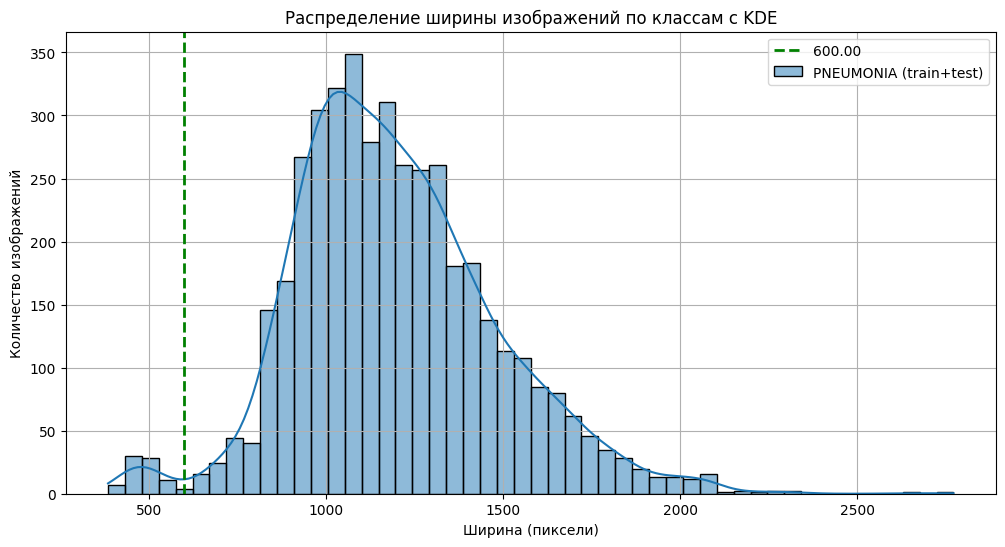

Список изображений, ширина которых меньше 600, сохранен в файл: ./images_less_threshold.txt
Количество изображений в файле: 78


In [15]:
import numpy as np

# Путь для сохранения списка изображений из процентиля
output_file = "./images_less_threshold.txt"

# Список для хранения путей к изображениям из процентиля
images_in_percentile = []

# Построение гистограмм и кривых распределения для каждого класса
plt.figure(figsize=(12, 6))

# Объединяем данные для train и test
class_name = 'PNEUMONIA'
# Ширины для train и test
train_widths = train_sizes_by_class[class_name]["widths"]
test_widths = test_sizes_by_class[class_name]["widths"]
all_widths = train_widths + test_widths

# Вычисление первого квантиля (p-й процентиль) для all_widths
p = 1.5
first_quartile = np.percentile(all_widths, p)

threshold = 600

# Гистограмма с KDE
sns.histplot(all_widths, bins=50, kde=True, alpha=0.5, label=f"{class_name} (train+test)")

# Добавляем вертикальную линию для threshold
plt.axvline(threshold, color='green', linestyle='--', linewidth=2,
                label=f"{threshold:.2f}")

# Фильтруем изображения, ширина которых <= threshold
for image_dir in [train_dir, test_dir]:
        class_dir = os.path.join(image_dir, class_name)
        if os.path.exists(class_dir):
            for image_name in os.listdir(class_dir):
                if image_name.endswith(".jpeg"):  # Используйте .jpg или .jpeg в зависимости от ваших данных
                    image_path = os.path.join(class_dir, image_name)
                    with Image.open(image_path) as img:
                        width, _ = img.size
                        if width <= threshold:
                            images_in_percentile.append(image_path)

plt.title("Распределение ширины изображений по классам с KDE")
plt.xlabel("Ширина (пиксели)")
plt.ylabel("Количество изображений")
plt.legend()
plt.grid(True)
plt.show()

# Сохранение списка изображений в файл
with open(output_file, "w") as f:
    for image_path in images_in_percentile:
        f.write(f"{image_path}\n")

print(f"Список изображений, ширина которых меньше {threshold}, сохранен в файл: {output_file}")

# Подсчет количества изображений в файле
with open(output_file, "r") as f:
    image_count = len(f.readlines())

print(f"Количество изображений в файле: {image_count}")

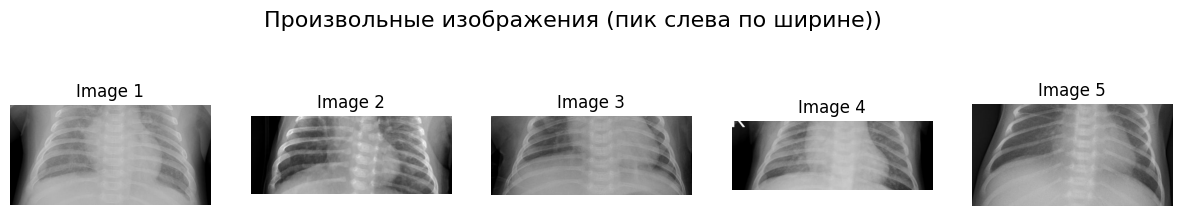

In [16]:
import random

# Чтение путей к изображениям из файла
with open(output_file, "r") as f:
    image_paths = [line.strip() for line in f.readlines()]

# Проверка, что файл не пуст
if not image_paths:
    print("Файл пуст. Нечего отображать.")
else:
    # Выбор 5 случайных изображений из списка
    if len(image_paths) >= 5:
        random_images = random.sample(image_paths, 5)
    else:
        random_images = image_paths  # Если изображений меньше 5, берем все

    # Отображение выбранных изображений
    plt.figure(figsize=(15, 3))
    for i, image_path in enumerate(random_images):
        img = Image.open(image_path)
        plt.subplot(1, 5, i + 1)  # 1 строка, 5 столбцов
        plt.imshow(img, cmap='gray')  # Отображаем изображение (для рентгеновских снимков часто используется grayscale)
        plt.title(f"Image {i + 1}")
        plt.axis('off')  # Отключаем оси

    plt.suptitle("Произвольные изображения (пик слева по ширине))", fontsize=16)
    plt.show()

### Пик на распределении высоты

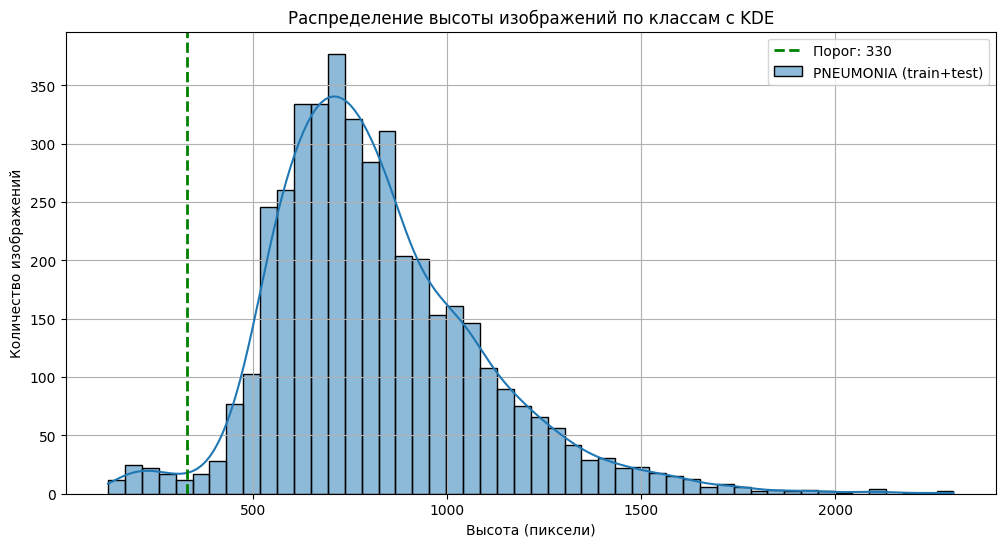

Список изображений, высота которых меньше 330, сохранен в файл: ./images_less_threshold_heights.txt
Количество изображений в файле: 86


In [17]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns

# Путь для сохранения списка изображений из процентиля
output_file = "./images_less_threshold_heights.txt"

# Список для хранения путей к изображениям из процентиля
images_in_percentile = []

# Построение гистограмм и кривых распределения для каждого класса
plt.figure(figsize=(12, 6))

# Объединяем данные для train и test
class_name = 'PNEUMONIA'
# Высоты для train и test
train_heights = train_sizes_by_class[class_name]["heights"]
test_heights = test_sizes_by_class[class_name]["heights"]
all_heights = train_heights + test_heights

threshold = 330

# Гистограмма с KDE
sns.histplot(all_heights, bins=50, kde=True, alpha=0.5, label=f"{class_name} (train+test)")

# Добавляем вертикальную линию для threshold
plt.axvline(threshold, color='green', linestyle='--', linewidth=2,
            label=f"Порог: {threshold}")

# Фильтруем изображения, высота которых <= threshold
for image_dir in [train_dir, test_dir]:
    class_dir = os.path.join(image_dir, class_name)
    if os.path.exists(class_dir):
        for image_name in os.listdir(class_dir):
            if image_name.endswith(".jpeg"):  # Используйте .jpg или .jpeg в зависимости от ваших данных
                image_path = os.path.join(class_dir, image_name)
                with Image.open(image_path) as img:
                    width, height = img.size  # Правильный порядок: (ширина, высота)
                    if height <= threshold:
                        images_in_percentile.append(image_path)

plt.title("Распределение высоты изображений по классам с KDE")
plt.xlabel("Высота (пиксели)")
plt.ylabel("Количество изображений")
plt.legend()
plt.grid(True)
plt.show()

# Сохранение списка изображений в файл
with open(output_file, "w") as f:
    for image_path in images_in_percentile:
        f.write(f"{image_path}\n")

print(f"Список изображений, высота которых меньше {threshold}, сохранен в файл: {output_file}")

# Подсчет количества изображений в файле
with open(output_file, "r") as f:
    image_count = len(f.readlines())

print(f"Количество изображений в файле: {image_count}")

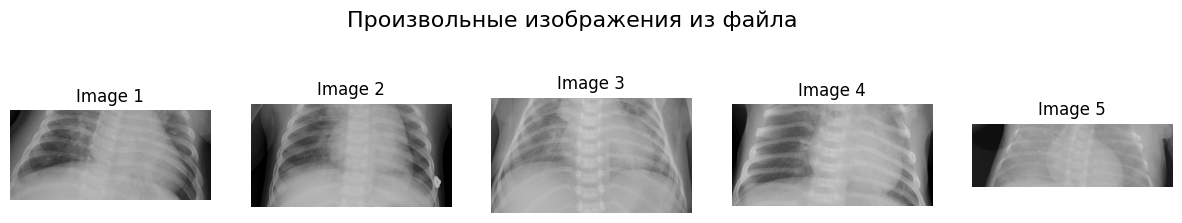

In [18]:
import random

# Чтение путей к изображениям из файла
with open(output_file, "r") as f:
    image_paths = [line.strip() for line in f.readlines()]

# Проверка, что файл не пуст
if not image_paths:
    print("Файл пуст. Нечего отображать.")
else:
    # Выбор 5 случайных изображений из списка
    if len(image_paths) >= 5:
        random_images = random.sample(image_paths, 5)
    else:
        random_images = image_paths  # Если изображений меньше 5, берем все

    # Отображение выбранных изображений
    plt.figure(figsize=(15, 3))
    for i, image_path in enumerate(random_images):
        img = Image.open(image_path)
        plt.subplot(1, 5, i + 1)  # 1 строка, 5 столбцов
        plt.imshow(img, cmap='gray')  # Отображаем изображение (для рентгеновских снимков часто используется grayscale)
        plt.title(f"Image {i + 1}")
        plt.axis('off')  # Отключаем оси

    plt.suptitle("Произвольные изображения из файла", fontsize=16)
    plt.show()

## Статистика по размерам изображений

In [19]:
import os
from PIL import Image
import pandas as pd

# Путь к папке с данными
train_dir = "./dataset_clean/chest_xray/train"

# Функция для получения размеров изображений по классам
def get_image_sizes_by_class(image_dir):
    sizes_by_class = {"NORMAL": {"widths": [], "heights": []}, "PNEUMONIA": {"widths": [], "heights": []}}

    for class_name in sizes_by_class.keys():
        class_dir = os.path.join(image_dir, class_name)

        if os.path.exists(class_dir):
            for image_name in os.listdir(class_dir):
                if image_name.lower().endswith((".jpeg", ".jpg", ".png")):  # Поддержка разных форматов
                    image_path = os.path.join(class_dir, image_name)
                    try:
                        with Image.open(image_path) as img:
                            width, height = img.size
                            sizes_by_class[class_name]["widths"].append(width)
                            sizes_by_class[class_name]["heights"].append(height)
                    except Exception as e:
                        print(f"Ошибка при обработке {image_path}: {e}")

    return sizes_by_class

# Получаем размеры изображений
train_sizes_by_class = get_image_sizes_by_class(train_dir)

# Создаём единый DataFrame для всех данных
data = []
for class_name in train_sizes_by_class.keys():
    for width, height in zip(train_sizes_by_class[class_name]["widths"],
                           train_sizes_by_class[class_name]["heights"]):
        data.append({
            "Ширина": width,
            "Высота": height,
            "Класс": class_name
        })

# Создаем итоговый DataFrame
final_df = pd.DataFrame(data)

In [20]:
# Проверяем результат
print(f"Всего записей: {len(final_df)}")

Всего записей: 5206


In [21]:
final_df.groupby('Класс').describe()

Ширина                                                          \
            count         mean         std    min     25%     50%     75%   
Класс                                                                       
NORMAL     1348.0  1666.053412  288.516972  912.0  1466.0  1638.0  1820.0   
PNEUMONIA  3858.0  1199.616900  291.297672  384.0  1000.0  1168.0  1368.0   

                   Высота                                                   \
              max   count         mean         std    min      25%     50%   
Класс                                                                        
NORMAL     2916.0  1348.0  1379.446588  324.514242  672.0  1151.75  1325.0   
PNEUMONIA  2772.0  3858.0   823.884655  276.741125  127.0   640.00   776.0   

                           
              75%     max  
Класс                      
NORMAL     1541.0  2663.0  
PNEUMONIA   968.0  2304.0

## Другие характеристики изображений

### Самое засвеченное изображение

Класс: NORMAL


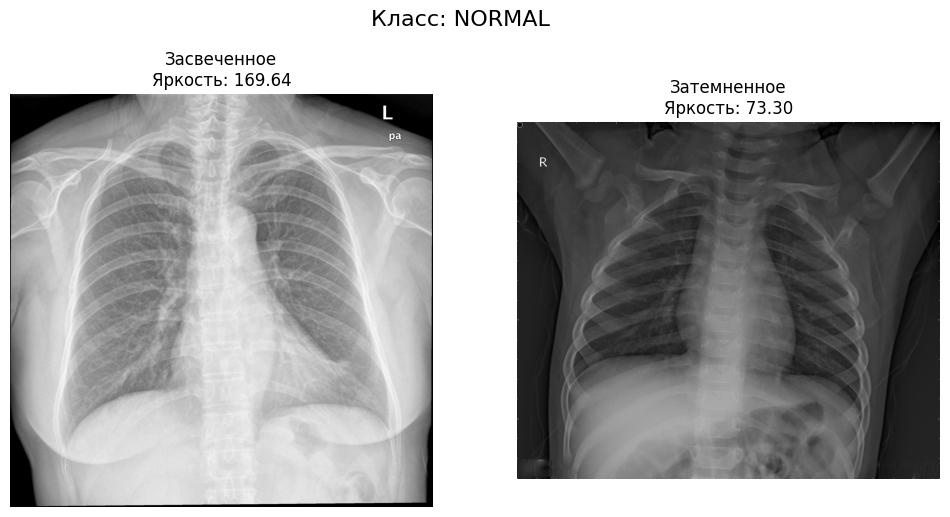

Класс: PNEUMONIA


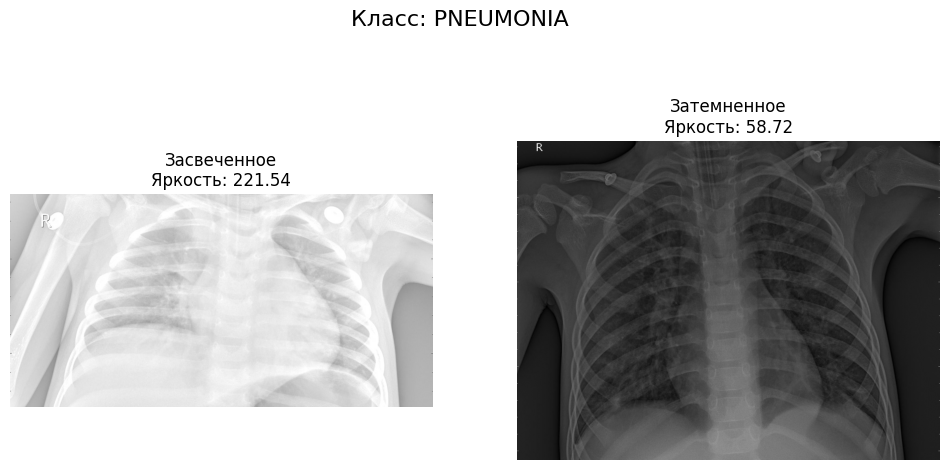

In [22]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# Функция для вычисления средней яркости изображения
def calculate_mean_brightness(image_path):
    """
    Вычисляет среднюю яркость изображения.

    :param image_path: Путь к изображению.
    :return: Средняя яркость изображения.
    """
    with Image.open(image_path).convert("L") as img:  # Преобразуем в градации серого
        pixels = np.array(img)
        mean_brightness = np.mean(pixels)  # Средняя яркость
        return mean_brightness

# Функция для отображения группы изображений
def visualize_images(images, titles, class_name):
    """
    Отображает группу изображений на одной горизонтали.

    :param images: Список путей к изображениям.
    :param titles: Список заголовков для изображений.
    :param class_name: Название класса.
    """
    num_images = len(images)
    fig, axes = plt.subplots(1, num_images, figsize=(6 * num_images, 6))

    if num_images == 1:  # Если только одно изображение, преобразуем axes в список
        axes = [axes]

    for i, (image_path, title) in enumerate(zip(images, titles)):
        with Image.open(image_path).convert("L") as img:
            axes[i].imshow(img, cmap='gray')
            axes[i].set_title(title)
            axes[i].axis('off')

    fig.suptitle(f"Класс: {class_name}", fontsize=16)
    plt.show()

# Поиск самых засвеченных и затемненных изображений для каждого класса
for class_name in train_sizes_by_class.keys():
    max_brightness = -1  # Инициализация минимального значения яркости
    min_brightness = float('inf')  # Инициализация максимального значения яркости
    brightest_image_path = None  # Путь к самому засвеченному изображению
    darkest_image_path = None  # Путь к самому затемненному изображению

    # Перебираем изображения в train и test
    for image_dir in [train_dir, test_dir]:
        class_dir = os.path.join(image_dir, class_name)
        if os.path.exists(class_dir):
            for image_name in os.listdir(class_dir):
                if image_name.endswith(".jpeg"):  # Используйте .jpg или .jpeg в зависимости от ваших данных
                    image_path = os.path.join(class_dir, image_name)
                    brightness = calculate_mean_brightness(image_path)

                    # Обновляем информацию о самом засвеченном изображении
                    if brightness > max_brightness:
                        max_brightness = brightness
                        brightest_image_path = image_path

                    # Обновляем информацию о самом затемненном изображении
                    if brightness < min_brightness:
                        min_brightness = brightness
                        darkest_image_path = image_path

    # Выводим результат для текущего класса
    print(f"Класс: {class_name}")

    # Собираем изображения и заголовки
    images_to_display = []
    titles = []

    if brightest_image_path:
        images_to_display.append(brightest_image_path)
        titles.append(f"Засвеченное\nЯркость: {max_brightness:.2f}")
    else:
        print("  Засвеченных изображений не найдено.")

    if darkest_image_path:
        images_to_display.append(darkest_image_path)
        titles.append(f"Затемненное\nЯркость: {min_brightness:.2f}")
    else:
        print("  Затемненных изображений не найдено.")

    # Отображаем изображения на одной горизонтали
    if images_to_display:
        visualize_images(images_to_display, titles, class_name)

# Изменение размера изображений

In [43]:
#расчитано ранее
scaling_size =(128,128)

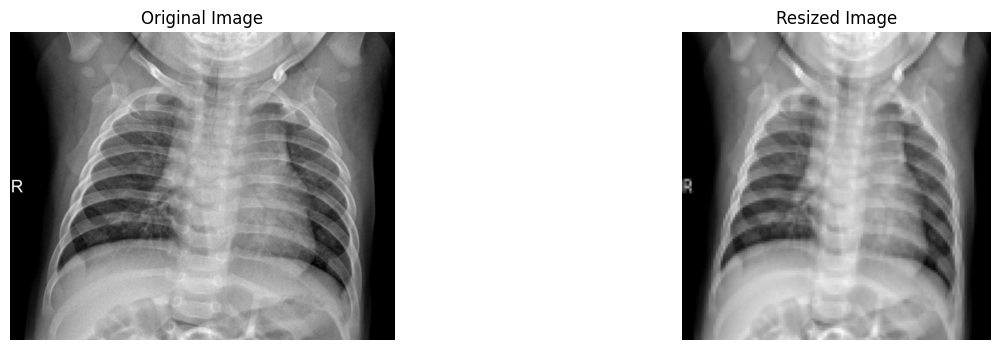

In [44]:
import os
import cv2
import matplotlib.pyplot as plt

# Путь к датасету и список классов
DATASET_DIR = 'dataset_clean/chest_xray/train'
classes = ['NORMAL', 'PNEUMONIA']

def resize_image(image, size):
    """
    Resizes image to a fixed size using INTER_AREA interpolation.
    """
    return cv2.resize(image, size, interpolation=cv2.INTER_AREA)

# Выбор одного изображения из класса NORMAL
normal_dir = os.path.join(train_dir, 'NORMAL')  # Путь к папке с изображениями класса NORMAL
normal_images = os.listdir(normal_dir)           # Список файлов в папке
original_image_path = os.path.join(normal_dir, normal_images[0])  # Берём первое изображение

# Загрузка изображения с помощью OpenCV
original_image = cv2.imread(original_image_path, cv2.IMREAD_GRAYSCALE)  # Загружаем в градациях серого

# Изменение размера изображения
#scaling_size = (128, 128)  # Желаемый размер
resized_img = resize_image(original_image, scaling_size)

# Визуализация оригинального и изменённого изображений
plt.figure(figsize=(15, 4))

# Оригинальное изображение
plt.subplot(1, 2, 1)
plt.imshow(original_image, cmap='gray')
plt.title('Original Image')
plt.axis('off')

# Изменённое изображение
plt.subplot(1, 2, 2)
plt.imshow(resized_img, cmap='gray')
plt.title('Resized Image')
plt.axis('off')

plt.show()

In [45]:
import os
import cv2

# Путь к датасету и список классов
DATASET_DIR = 'dataset_clean/chest_xray/train'
classes = ['NORMAL', 'PNEUMONIA']

# Желаемый размер для изменённых изображений
scaling_size = (128, 128)

# Создание новых папок для изменённых изображений
output_dir = 'dataset/chest_xray/resized_train'  # Директория для сохранения изменённых изображений
os.makedirs(output_dir, exist_ok=True)  # Создаём основную папку, если её нет

for class_name in classes:
    # Путь к исходной папке с изображениями
    class_dir = os.path.join(train_dir, class_name)

    # Путь к новой папке для изменённых изображений
    resized_class_dir = os.path.join(output_dir, f'resized_{class_name}')
    os.makedirs(resized_class_dir, exist_ok=True)  # Создаём папку для изменённых изображений

    # Обработка всех изображений в текущей папке
    for image_name in os.listdir(class_dir):
        # Проверка расширения файла
        if not image_name.lower().endswith('.jpeg'):
            print(f"Пропускаем файл {image_name} (неподдерживаемое расширение)")
            continue

        # Полный путь к исходному изображению
        image_path = os.path.join(class_dir, image_name)

        # Загрузка изображения в градациях серого
        original_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

        # Проверка, что изображение успешно загружено
        if original_image is None:
            print(f"Ошибка загрузки файла {image_name}")
            continue

        # Изменение размера изображения
        resized_img = resize_image(original_image, scaling_size)

        # Сохранение изменённого изображения
        resized_image_path = os.path.join(resized_class_dir, image_name)
        cv2.imwrite(resized_image_path, resized_img)

print("Все изображения успешно изменены и сохранены.")

Все изображения успешно изменены и сохранены.


#Среднее изображение

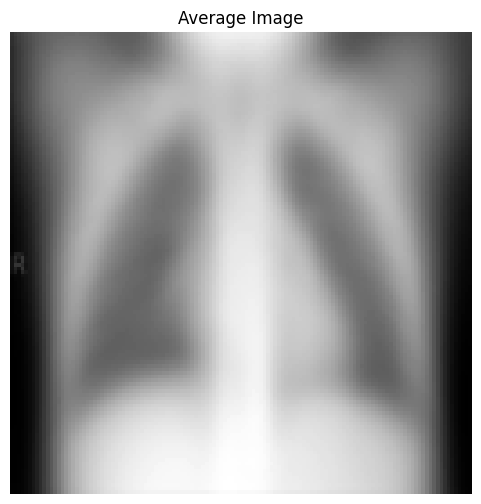

In [46]:
import numpy as np

# Путь к папке с изображениями класса NORMAL
resized_dir = os.path.join('dataset/chest_xray/resized_train', 'resized_NORMAL')
resized_images = os.listdir(resized_dir)  # Список файлов в папке

# Инициализация переменной для накопления суммы изображений
average_image = None

# Перебор всех изображений
for i, image_name in enumerate(resized_images):
    # Загрузка изображения в градациях серого
    image_path = os.path.join(resized_dir, image_name)
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # Преобразование изображения в float32 для точного вычисления среднего
    image = image.astype(np.float32)

    # Если average_image ещё не инициализирован, используем первое изображение
    if average_image is None:
        average_image = np.zeros_like(image)

    # Добавление изображения к сумме
    average_image += image

# Деление суммы на количество изображений для получения среднего
average_image /= len(resized_images)

# Преобразование обратно в uint8 для отображения
average_image = average_image.astype(np.uint8)

# Визуализация усредненного изображения
plt.figure(figsize=(6, 6))
plt.imshow(average_image, cmap='gray')
plt.title('Average Image')
plt.axis('off')
plt.show()

Получилось очень забавно - позвоночник и два легких есть у всех людей :)